# Basic Information

recognition/s45533675/Demo3.ipynb

Requirement: Implement a brain MRI super-resolution network by training on the ADNI brain dataset. Create down-sampled data (approximately by a factor of 4) using Tensorflow implementations. The network should be trained to up-scale from 4x down-sampled input and produce a “reasonably clear image".

# Set Up Environment


In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

TF Version: 2.9.2


# Load data

Download dataset.
I use the built-in keras.utils.get_file utility to retrieve the dataset.

In [2]:
dataset_url = "https://cloudstor.aarnet.edu.au/plus/s/L6bbssKhUoUdTSI/download"
data_dir = keras.utils.get_file(origin=dataset_url, fname="ADNI", extract=True)


*   Because this task is not a classification problem, I just use the images in the AD train as my whole dataset.
*   The number of images is 10400 and it completely fits the training requirement.
*   The origin path is ADNI_AD_NC_2D\AD_NC\train\AD and I rename the ADNI_AD_NC_2D to ADNI and newpath is ADNI\AD_NC\train\AD.

In [3]:
root_dir = os.path.join("/root/.keras/datasets/AD_NC/train/AD")

Then I create training and validation datasets via image_dataset_from_directory.

The image size is 256 x 240. The number of images is 10400 so I choose 10% as validation set which is 1040.

# Make train set and valid set

In [4]:
crop_size = 300
upscale_factor = 4
input_size = crop_size // upscale_factor
batch_size = 20

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.1,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.1,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 10400 files belonging to 1 classes.
Using 9360 files for training.
Found 10400 files belonging to 1 classes.
Using 1040 files for validation.


# Pre process images

Normalization

I rescale the images to take values in the range [0, 1].

In [5]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Demonstrate the first batch.

I use images in AD_NC/test/AD as test images for visual evaluation at the end.


In [6]:
test_path = os.path.join("/root/.keras/datasets/AD_NC/test/AD")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpeg")
    ]
)

*   I downsample the original images to low-resolution images, and the original images are high-resolution images.
*   Set low-resolution images to 0 axis, high-resolution images to 1 axis.



In [7]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Show the first processed batch.

# Build the model

In [8]:
def get_model(upscale_factor, channels):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 120, 150, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".jpeg")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [10]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


# Run here

In [11]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)



In [12]:
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

# Train

Epoch 1/30
Mean PSNR for epoch: 29.86
1/1 [==============================] - 0s 108ms/step


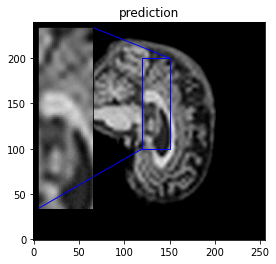

468/468 - 9s - loss: 0.0020 - val_loss: 0.0010 - 9s/epoch - 19ms/step
Epoch 2/30
Mean PSNR for epoch: 30.10
468/468 - 5s - loss: 0.0010 - val_loss: 9.8252e-04 - 5s/epoch - 10ms/step
Epoch 3/30
Mean PSNR for epoch: 30.28
468/468 - 5s - loss: 9.6031e-04 - val_loss: 9.4620e-04 - 5s/epoch - 10ms/step
Epoch 4/30
Mean PSNR for epoch: 30.43
468/468 - 5s - loss: 9.2163e-04 - val_loss: 9.1150e-04 - 5s/epoch - 10ms/step
Epoch 5/30
Mean PSNR for epoch: 30.59
468/468 - 5s - loss: 8.9129e-04 - val_loss: 8.8240e-04 - 5s/epoch - 10ms/step
Epoch 6/30
Mean PSNR for epoch: 30.64
468/468 - 5s - loss: 8.6774e-04 - val_loss: 8.6424e-04 - 5s/epoch - 10ms/step
Epoch 7/30
Mean PSNR for epoch: 30.62
468/468 - 5s - loss: 8.5693e-04 - val_loss: 8.6989e-04 - 5s/epoch - 10ms/step
Epoch 8/30
Mean PSNR for epoch: 30.69
468/468 - 5s - loss: 8.4489e-04 - val_loss: 8.5102e-04 - 5s/epoch - 10ms/step
Epoch 9/30
Mean PSNR for epoch: 30.68
468/468 - 5s - loss: 8.3942e-04 - val_loss: 8.5775e-04 - 5s/epoch - 10ms/step
Epoch 

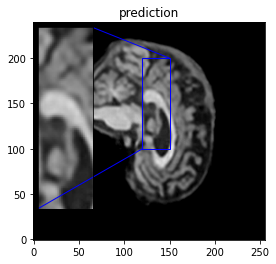

468/468 - 5s - loss: 7.9072e-04 - val_loss: 7.9737e-04 - 5s/epoch - 11ms/step
Epoch 22/30
Mean PSNR for epoch: 31.04
468/468 - 5s - loss: 7.8822e-04 - val_loss: 7.9517e-04 - 5s/epoch - 10ms/step
Epoch 23/30
Mean PSNR for epoch: 31.02
468/468 - 5s - loss: 7.8504e-04 - val_loss: 7.9067e-04 - 5s/epoch - 10ms/step
Epoch 24/30
Mean PSNR for epoch: 31.02
468/468 - 5s - loss: 7.8365e-04 - val_loss: 7.9029e-04 - 5s/epoch - 10ms/step
Epoch 25/30
Mean PSNR for epoch: 31.04
468/468 - 5s - loss: 7.8151e-04 - val_loss: 7.8921e-04 - 5s/epoch - 10ms/step
Epoch 26/30
Mean PSNR for epoch: 31.09
468/468 - 5s - loss: 7.7889e-04 - val_loss: 7.8459e-04 - 5s/epoch - 10ms/step
Epoch 27/30
Mean PSNR for epoch: 31.06
468/468 - 5s - loss: 7.7756e-04 - val_loss: 7.8208e-04 - 5s/epoch - 10ms/step
Epoch 28/30
Mean PSNR for epoch: 30.92
468/468 - 5s - loss: 7.7442e-04 - val_loss: 8.1176e-04 - 5s/epoch - 10ms/step
Epoch 29/30
Mean PSNR for epoch: 31.12
468/468 - 5s - loss: 7.7285e-04 - val_loss: 7.7929e-04 - 5s/epoc

In [13]:
epochs = 30

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

# Prediction

If the image is a JPEG (with the extension “. jpg”), it will always be an 8-bit image. Typical values for the PSNR in the lossy image and video compression are between 30 and 50 dB, provided the bit depth is 8 bits, where higher is better.

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.3126
PSNR of predict and high resolution is 27.0188


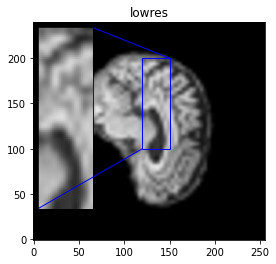

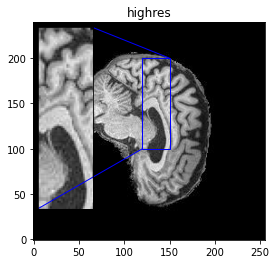

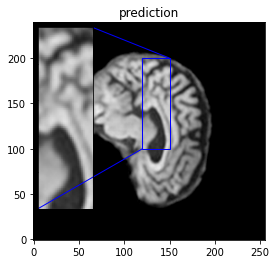

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.7794
PSNR of predict and high resolution is 27.4426


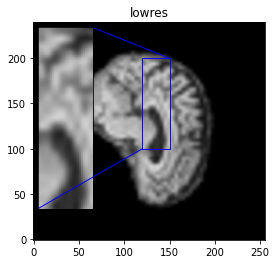

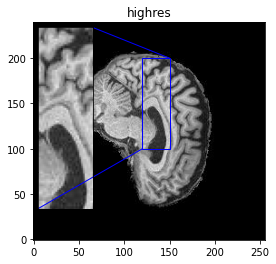

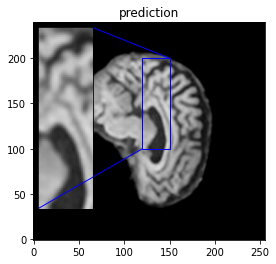

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.1511
PSNR of predict and high resolution is 26.7654


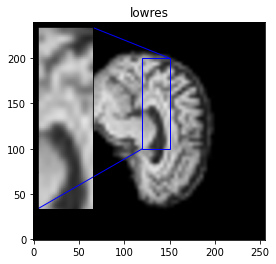

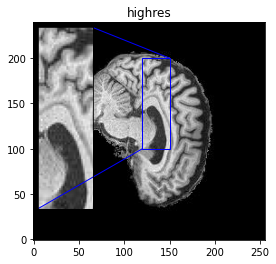

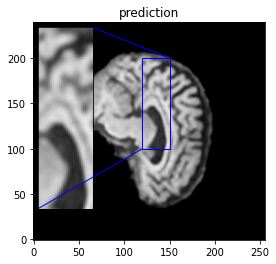

1/1 [==============================] - 0s 18ms/step
PSNR of low resolution image and high resolution image is 25.3360
PSNR of predict and high resolution is 26.9351


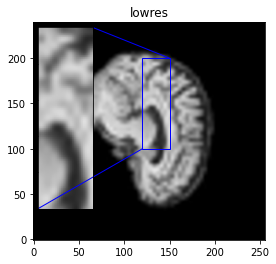

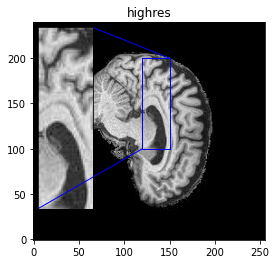

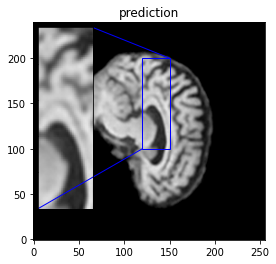

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.5713
PSNR of predict and high resolution is 27.0065


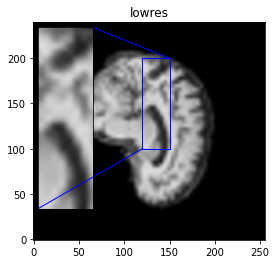

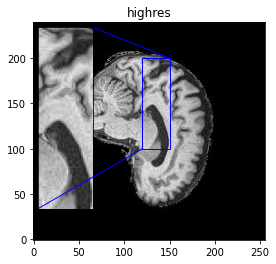

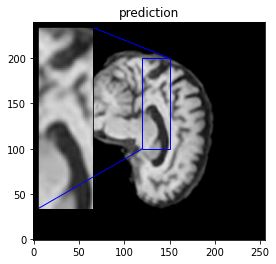

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.6523
PSNR of predict and high resolution is 27.1046


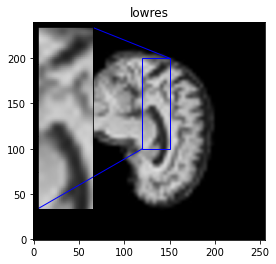

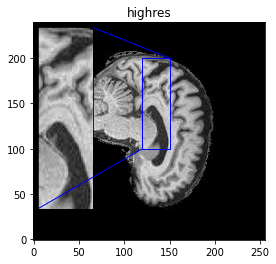

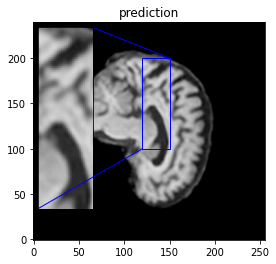

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.4096
PSNR of predict and high resolution is 26.8284


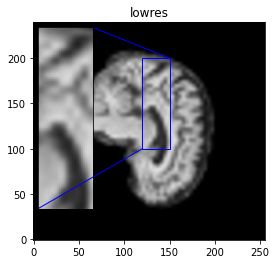

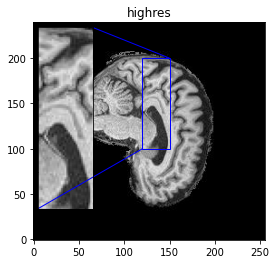

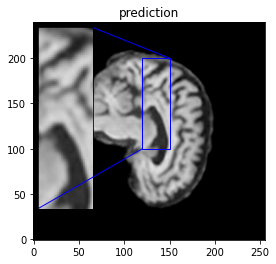

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.4071
PSNR of predict and high resolution is 26.8459


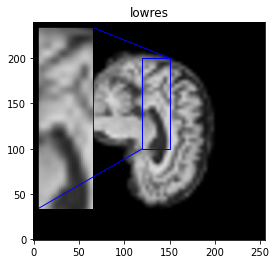

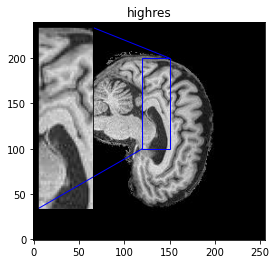

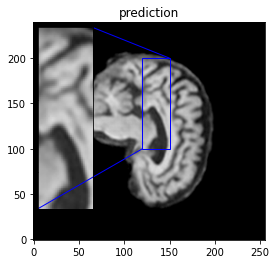

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.0772
PSNR of predict and high resolution is 26.6401


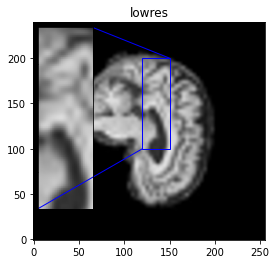

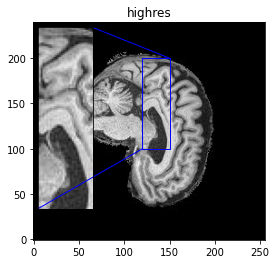

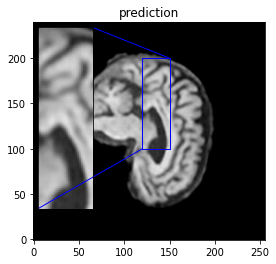

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.2648
PSNR of predict and high resolution is 26.8776


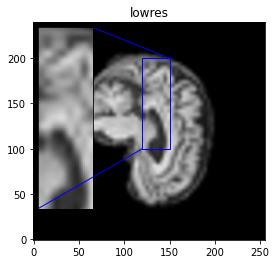

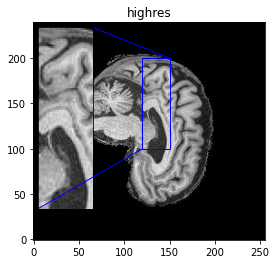

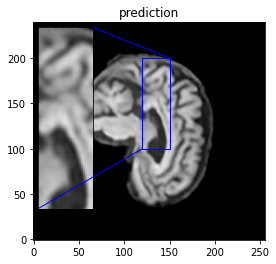

Avg. PSNR of lowres images is 25.3961
Avg. PSNR of reconstructions is 26.9465


In [14]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

Improvement
1. make bigger filter size
2. loss function

Result
1. more deeper model doesnot better
2. there is no influence whether 0.1 or 0.2 
4. small batch can increase PSNR
5. larger crop size will increase computation costs, decrese the PSNR
